---

_You are currently looking at **version 1.2** of this notebook. To download notebooks and datafiles, as well as get help on Jupyter notebooks in the Coursera platform, visit the [Jupyter Notebook FAQ](https://www.coursera.org/learn/python-social-network-analysis/resources/yPcBs) course resource._

---

# Assignment 4

In [1]:
import networkx as nx
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt

---

## Part 1 - Random Graph Identification

For the first part of this assignment you will analyze randomly generated graphs and determine which algorithm created them.

In [2]:
P1_Graphs = pickle.load(open('A4_graphs','rb'))
P1_Graphs

<br>
`P1_Graphs` is a list containing 5 networkx graphs. Each of these graphs were generated by one of three possible algorithms:
* Preferential Attachment (`'PA'`)
* Small World with low probability of rewiring (`'SW_L'`)
* Small World with high probability of rewiring (`'SW_H'`)

Anaylze each of the 5 graphs and determine which of the three algorithms generated the graph.

*The `graph_identification` function should return a list of length 5 where each element in the list is either `'PA'`, `'SW_L'`, or `'SW_H'`.*

In [3]:
def degree_test(G):
    
    degrees = G.degree()
    degree_values = sorted(set(degrees.values()))
    histogram = [list(degrees.values()).count(i)/float(nx.number_of_nodes(G)) for i in degree_values]

    plt.plot(degree_values,histogram,'o')
    plt.xlabel('Degree')
    plt.ylabel('Fraction of Nodes')
    plt.xscale('log')
    plt.yscale('log')
    plt.show()
    
    return

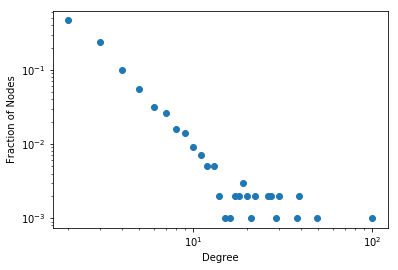

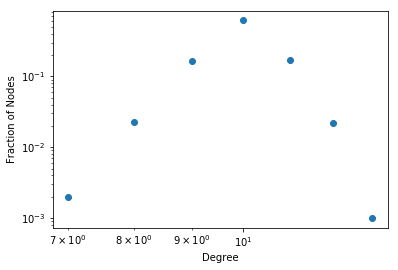

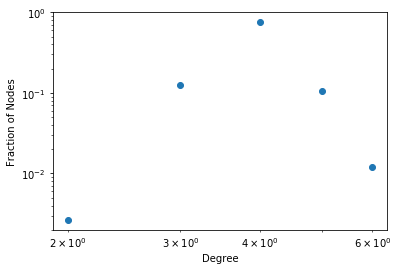

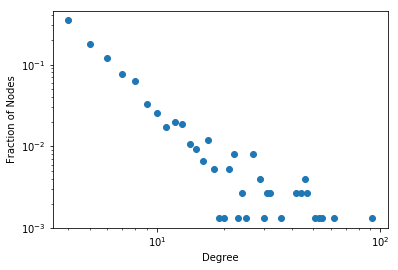

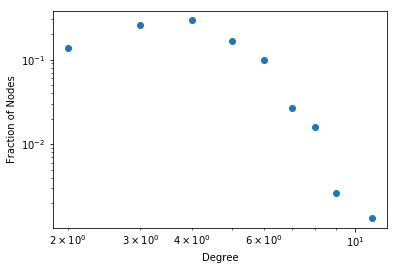

['PA', 'SW_L', 'SW_L', 'PA', 'SW_H']

In [20]:
def graph_identification():

    graph_info = []

    for G in P1_Graphs:
        degree_test(G)
        info = nx.info(G)
        graph_info.append(info)
        
    return ['PA','SW_L','SW_L','PA','SW_H']

graph_identification()

---

## Part 2 - Company Emails

For the second part of this assignment you will be workking with a company's email network where each node corresponds to a person at the company, and each edge indicates that at least one email has been sent between two people.

The network also contains the node attributes `Department` and `ManagementSalary`.

`Department` indicates the department in the company which the person belongs to, and `ManagementSalary` indicates whether that person is receiving a management position salary.

In [5]:
G = nx.read_gpickle('email_prediction.txt')

print(nx.info(G))

Name: 
Type: Graph
Number of nodes: 1005
Number of edges: 16706
Average degree:  33.2458


### Part 2A - Salary Prediction

Using network `G`, identify the people in the network with missing values for the node attribute `ManagementSalary` and predict whether or not these individuals are receiving a management position salary.

To accomplish this, you will need to create a matrix of node features using networkx, train a sklearn classifier on nodes that have `ManagementSalary` data, and predict a probability of the node receiving a management salary for nodes where `ManagementSalary` is missing.



Your predictions will need to be given as the probability that the corresponding employee is receiving a management position salary.

The evaluation metric for this assignment is the Area Under the ROC Curve (AUC).

Your grade will be based on the AUC score computed for your classifier. A model which with an AUC of 0.88 or higher will receive full points, and with an AUC of 0.82 or higher will pass (get 80% of the full points).

Using your trained classifier, return a series of length 252 with the data being the probability of receiving management salary, and the index being the node id.

    Example:
    
        1       1.0
        2       0.0
        5       0.8
        8       1.0
            ...
        996     0.7
        1000    0.5
        1001    0.0
        Length: 252, dtype: float64

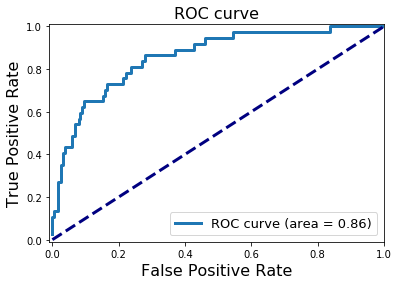

1       0.145333
2       0.559729
5       0.954001
8       0.125741
14      0.333141
18      0.172949
27      0.257150
30      0.306356
31      0.180278
34      0.123921
37      0.118915
40      0.233166
45      0.172445
54      0.236619
55      0.187937
60      0.200156
62      0.993425
65      0.421009
77      0.070415
79      0.121319
97      0.096659
101     0.082690
103     0.182128
108     0.123153
113     0.443892
122     0.064246
141     0.406029
142     0.898737
144     0.091532
145     0.406373
          ...   
913     0.067348
914     0.085670
915     0.017799
918     0.104873
923     0.050692
926     0.082836
931     0.071183
934     0.042617
939     0.028080
944     0.020875
945     0.048826
947     0.087544
950     0.158444
951     0.058481
953     0.048568
959     0.016215
962     0.018016
963     0.147960
968     0.077819
969     0.072342
974     0.060110
984     0.041036
987     0.088594
989     0.071281
991     0.096035
992     0.017523
994     0.020328
996     0.0185

In [18]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score,confusion_matrix,precision_recall_curve,roc_curve,auc


def salary_predictions():
    
    # Create a df of node-based features from the graph
    
    df = pd.DataFrame(index=G.nodes())
    df['Department'] = pd.Series(nx.get_node_attributes(G, 'Department'))
    df['ManagementSalary'] = pd.Series(nx.get_node_attributes(G, 'ManagementSalary'))
    df['clustering'] = pd.Series(nx.clustering(G))
    df['degree'] = pd.Series(G.degree())
    
    # Get the train and test dfs
    
    train_df = df[df['ManagementSalary'].notnull()]
    y = train_df['ManagementSalary']
    X = train_df.drop(['ManagementSalary'],axis=1)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
    
    # Train a Logistic Regression classifier
    
    clf = LogisticRegression(random_state = 0)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    confusion = confusion_matrix(y_test, y_pred)
    
    y_score = clf.fit(X_train, y_train).decision_function(X_test)
    fpr, tpr, _ = roc_curve(y_test, y_score)
    roc_auc = auc(fpr, tpr)
    
    plt.figure()
    plt.xlim([-0.01, 1.00])
    plt.ylim([-0.01, 1.01])
    plt.plot(fpr, tpr, lw=3, label='ROC curve (area = {:0.2f})'.format(roc_auc))
    plt.xlabel('False Positive Rate', fontsize=16)
    plt.ylabel('True Positive Rate', fontsize=16)
    plt.title('ROC curve', fontsize=16)
    plt.legend(loc='lower right', fontsize=13)
    plt.plot([0, 1], [0, 1], color='navy', lw=3, linestyle='--')
    # plt.axes().set_aspect('equal')
    plt.show()
    
    test_df = df[df['ManagementSalary'].isnull()]
    test_df = test_df.drop(['ManagementSalary'],axis=1)
    
    y_probs = clf.fit(X_train, y_train).predict_proba(test_df)
    
    result = pd.Series(y_probs[:,1],index=test_df.index)
    
    return result


salary_predictions()

### Part 2B - New Connections Prediction

For the last part of this assignment, you will predict future connections between employees of the network. The future connections information has been loaded into the variable `future_connections`. The index is a tuple indicating a pair of nodes that currently do not have a connection, and the `Future Connection` column indicates if an edge between those two nodes will exist in the future, where a value of 1.0 indicates a future connection.

In [9]:
future_connections = pd.read_csv('Future_Connections.csv', index_col=0, converters={0: eval})
future_connections.info()

<class 'pandas.core.frame.DataFrame'>
Index: 488446 entries, (6, 840) to (75, 101)
Data columns (total 1 columns):
Future Connection    366334 non-null float64
dtypes: float64(1)
memory usage: 7.5+ MB


Using network `G` and `future_connections`, identify the edges in `future_connections` with missing values and predict whether or not these edges will have a future connection.

To accomplish this, you will need to create a matrix of features for the edges found in `future_connections` using networkx, train a sklearn classifier on those edges in `future_connections` that have `Future Connection` data, and predict a probability of the edge being a future connection for those edges in `future_connections` where `Future Connection` is missing.



Your predictions will need to be given as the probability of the corresponding edge being a future connection.

The evaluation metric for this assignment is the Area Under the ROC Curve (AUC).

Your grade will be based on the AUC score computed for your classifier. A model which with an AUC of 0.88 or higher will receive full points, and with an AUC of 0.82 or higher will pass (get 80% of the full points).

Using your trained classifier, return a series of length 122112 with the data being the probability of the edge being a future connection, and the index being the edge as represented by a tuple of nodes.

    Example:
    
        (107, 348)    0.35
        (542, 751)    0.40
        (20, 426)     0.55
        (50, 989)     0.35
                  ...
        (939, 940)    0.15
        (555, 905)    0.35
        (75, 101)     0.65
        Length: 122112, dtype: float64

In [10]:
# Create a df of non_edge-based features from the graph G
    
df = pd.DataFrame(index=nx.non_edges(G))
df['Common Neighbors'] = [len(list(nx.common_neighbors(G,e[0],e[1]))) for e in nx.non_edges(G)]
df['Jaccard Coefficient'] = [x[2] for x in list(nx.jaccard_coefficient(G))]
df['Resource Allocation'] = [x[2] for x in list(nx.resource_allocation_index(G))]
df['Adamic Adar'] = [x[2] for x in list(nx.adamic_adar_index(G))]
df['Preferential Attachment'] = [x[2] for x in list(nx.preferential_attachment(G))]
df.head()

,Common Neighbors,Jaccard Coefficient,Resource Allocation,Adamic Adar,Preferential Attachment
"(0, 2)",6,0.045802,0.055340,1.257626,4180
"(0, 3)",3,0.027273,0.021388,0.605728,3124
"(0, 4)",3,0.022222,0.021388,0.605728,4224
"(0, 7)",4,0.036364,0.061668,0.938816,3168
"(0, 8)",1,0.012821,0.011628,0.224500,1628


In [15]:
# Merge df with future_connections to get new_df

new_df = pd.merge(future_connections, df, left_index=True, right_index=True)
print(new_df.shape)
new_df.head()

(488446, 6)


,Future Connection,Common Neighbors,Jaccard Coefficient,Resource Allocation,Adamic Adar,Preferential Attachment
"(6, 840)",0.0,9,0.073770,0.136721,2.110314,2070
"(4, 197)",0.0,2,0.015504,0.008437,0.363528,3552
"(620, 979)",0.0,0,0.000000,0.000000,0.000000,28
"(519, 872)",0.0,2,0.060606,0.039726,0.507553,299
"(382, 423)",0.0,0,0.000000,0.000000,0.000000,205


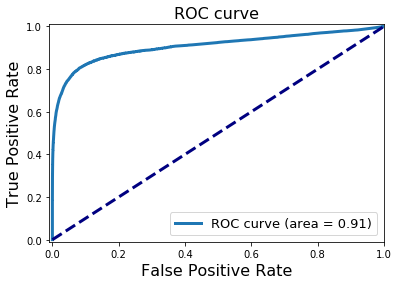

(107, 348)    0.039070
(542, 751)    0.013821
(20, 426)     0.520070
(50, 989)     0.014066
(942, 986)    0.014332
(324, 857)    0.014032
(13, 710)     0.260821
(19, 271)     0.091184
(319, 878)    0.014151
(659, 707)    0.013846
(49, 843)     0.014228
(208, 893)    0.013905
(377, 469)    0.006442
(405, 999)    0.026735
(129, 740)    0.019324
(292, 618)    0.033703
(239, 689)    0.014168
(359, 373)    0.008939
(53, 523)     0.039475
(276, 984)    0.014215
(202, 997)    0.014267
(604, 619)    0.059675
(270, 911)    0.014164
(261, 481)    0.062437
(200, 450)    0.934489
(213, 634)    0.013746
(644, 735)    0.063114
(346, 553)    0.013153
(521, 738)    0.012062
(422, 953)    0.022191
                ...   
(672, 848)    0.014164
(28, 127)     0.954146
(202, 661)    0.013053
(54, 195)     0.999988
(295, 864)    0.013994
(814, 936)    0.013784
(839, 874)    0.014332
(139, 843)    0.014015
(461, 544)    0.011339
(68, 487)     0.011216
(622, 932)    0.013935
(504, 936)    0.016829
(479, 528) 

In [19]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score,confusion_matrix,precision_recall_curve,roc_curve,auc

def new_connections_predictions():
    
    # Get the train and test dfs
    
    train_df = new_df[new_df['Future Connection'].notnull()]
    y = train_df['Future Connection']
    X = train_df.drop(['Future Connection'],axis=1)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
    
    # Train a Logistic Regression classifier
    
    clf = LogisticRegression(random_state = 0)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    confusion = confusion_matrix(y_test, y_pred)
    
    y_score = clf.fit(X_train, y_train).decision_function(X_test)
    fpr, tpr, _ = roc_curve(y_test, y_score)
    roc_auc = auc(fpr, tpr)
    
    plt.figure()
    plt.xlim([-0.01, 1.00])
    plt.ylim([-0.01, 1.01])
    plt.plot(fpr, tpr, lw=3, label='ROC curve (area = {:0.2f})'.format(roc_auc))
    plt.xlabel('False Positive Rate', fontsize=16)
    plt.ylabel('True Positive Rate', fontsize=16)
    plt.title('ROC curve', fontsize=16)
    plt.legend(loc='lower right', fontsize=13)
    plt.plot([0, 1], [0, 1], color='navy', lw=3, linestyle='--')
    # plt.axes().set_aspect('equal')
    plt.show()
    
    test_df = new_df[new_df['Future Connection'].isnull()]
    test_df = test_df.drop(['Future Connection'],axis=1)
    
    y_probs = clf.fit(X_train, y_train).predict_proba(test_df)
    
    result = pd.Series(y_probs[:,1],index=test_df.index)
    
    return result

new_connections_predictions()